In [58]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from line_profiler import LineProfiler
import scienceplots
import itertools

plt.style.use(["ieee", "nature", "notebook", "no-latex"])

In [59]:
#Import data
(trainX, trainY), (testX, testY) = mnist.load_data()

# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 784))
testX = testX.reshape((testX.shape[0],784))
trainX = trainX/255 # normalized pixel
trainX = trainX.T
testX = testX/255 # Normalized pixel
testX = testX.T

n, m = trainX.shape
n, m

(784, 60000)

### Classical Neural Networks

In [18]:
def compute_loss(Y,A2): # a revoir 
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    
    return dZ2

In [27]:
#NN implementation
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2


def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    losses, accuracies = [], []
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            loss = compute_loss(Y,A2)
            accuracy = get_accuracy(predictions, Y)
            losses.append(loss)
            accuracies.append(accuracy)
            print(accuracy)
    return W1, b1, W2, b2, losses, accuracies

W1, b1, W2, b2, losses_classical, accuracies_classical = gradient_descent(trainX, trainY, 0.10, 1000)

Iteration:  0
[5 9 5 ... 9 5 5] [5 0 4 ... 5 6 8]
0.10721666666666667
Iteration:  10
[5 0 0 ... 7 0 0] [5 0 4 ... 5 6 8]
0.16735
Iteration:  20
[5 0 0 ... 1 0 0] [5 0 4 ... 5 6 8]
0.2263
Iteration:  30
[5 0 4 ... 1 0 0] [5 0 4 ... 5 6 8]
0.3203
Iteration:  40
[5 0 4 ... 1 0 0] [5 0 4 ... 5 6 8]
0.3933833333333333
Iteration:  50
[3 0 4 ... 1 0 2] [5 0 4 ... 5 6 8]
0.4466833333333333
Iteration:  60
[3 0 4 ... 8 0 2] [5 0 4 ... 5 6 8]
0.4882166666666667
Iteration:  70
[3 0 4 ... 8 0 2] [5 0 4 ... 5 6 8]
0.5253166666666667
Iteration:  80
[5 0 4 ... 5 6 2] [5 0 4 ... 5 6 8]
0.5664166666666667
Iteration:  90
[5 0 4 ... 5 6 7] [5 0 4 ... 5 6 8]
0.5997166666666667
Iteration:  100
[5 0 4 ... 5 6 7] [5 0 4 ... 5 6 8]
0.6253166666666666
Iteration:  110
[5 0 4 ... 5 6 7] [5 0 4 ... 5 6 8]
0.6459666666666667
Iteration:  120
[5 0 4 ... 5 6 7] [5 0 4 ... 5 6 8]
0.66485
Iteration:  130
[5 0 4 ... 5 6 7] [5 0 4 ... 5 6 8]
0.6802666666666667
Iteration:  140
[5 0 4 ... 5 6 7] [5 0 4 ... 5 6 8]
0.69446666

## Line profiling

In [5]:
from line_profiler import LineProfiler

In [23]:
arg = {"X":trainX, "Y":trainY, "alpha":0.10, "iterations":1000}

lp_classical = LineProfiler()
lp_wrapper = lp_classical(gradient_descent)
lp_wrapper(**arg)

Iteration:  0
[1 1 4 ... 4 4 8] [5 0 4 ... 5 6 8]
0.08273333333333334
Iteration:  10
[1 1 4 ... 4 4 3] [5 0 4 ... 5 6 8]
0.16771666666666665
Iteration:  20
[3 3 4 ... 4 6 8] [5 0 4 ... 5 6 8]
0.22566666666666665
Iteration:  30
[1 0 4 ... 4 0 8] [5 0 4 ... 5 6 8]
0.2810166666666667
Iteration:  40
[1 0 4 ... 4 0 8] [5 0 4 ... 5 6 8]
0.3416666666666667
Iteration:  50
[1 0 4 ... 4 0 8] [5 0 4 ... 5 6 8]
0.40521666666666667
Iteration:  60
[1 0 4 ... 4 0 8] [5 0 4 ... 5 6 8]
0.46285
Iteration:  70
[1 0 4 ... 8 0 8] [5 0 4 ... 5 6 8]
0.5084166666666666
Iteration:  80
[1 0 4 ... 8 0 8] [5 0 4 ... 5 6 8]
0.54305
Iteration:  90
[3 0 4 ... 8 0 8] [5 0 4 ... 5 6 8]
0.5719333333333333
Iteration:  100
[3 0 4 ... 8 0 8] [5 0 4 ... 5 6 8]
0.5969333333333333
Iteration:  110
[3 0 4 ... 8 0 8] [5 0 4 ... 5 6 8]
0.6203166666666666
Iteration:  120
[3 0 4 ... 8 0 8] [5 0 4 ... 5 6 8]
0.6415833333333333
Iteration:  130
[3 0 4 ... 8 0 8] [5 0 4 ... 5 6 8]
0.6598166666666667
Iteration:  140
[3 0 4 ... 8 0 8] [

(array([[-0.01244819, -0.17742699,  0.24672195, ...,  0.11323177,
         -0.27733552,  0.13391748],
        [-0.30900234,  0.13869076,  0.1167821 , ..., -0.48106993,
         -0.39417844, -0.32361917],
        [-0.29849709,  0.20311723, -0.34020069, ..., -0.18785683,
          0.3591462 , -0.49432055],
        ...,
        [-0.17189489, -0.31451777,  0.00531855, ..., -0.36435241,
         -0.0264646 ,  0.30730172],
        [ 0.38588015, -0.31711004,  0.46929858, ...,  0.03497943,
         -0.1668723 ,  0.1199615 ],
        [ 0.28462578,  0.33571538,  0.41322229, ...,  0.22108508,
         -0.17389196, -0.41321529]]),
 array([[1.11065833],
        [0.63066621],
        [0.41031315],
        [0.87308489],
        [1.22565035],
        [1.19830138],
        [0.55101528],
        [0.40404259],
        [0.54494133],
        [1.31420467]]),
 array([[-0.23688793, -0.14676778, -0.07201782,  0.05706752,  0.68272207,
         -0.42390573, -0.11856764,  0.81524875, -0.23138855, -0.28828239],
  

In [27]:
lp_classical

Timer unit: 1e-07 s

Total time: 140.474 s
File: C:\Users\Hermes\AppData\Local\Temp\ipykernel_6428\4005128679.py
Function: gradient_descent at line 57

Line #      Hits         Time  Per Hit   % Time  Line Contents
    57                                           def gradient_descent(X, Y, alpha, iterations):
    58         1       2072.0   2072.0      0.0      W1, b1, W2, b2 = init_params()
    59         1         12.0     12.0      0.0      losses, accuracies = [], []
    60      1001      11853.0     11.8      0.0      for i in range(iterations):
    61      1000  760521424.0 760521.4     54.1          Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    62      1000  629602223.0 629602.2     44.8          dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
    63      1000     649651.0    649.7      0.0          W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
    64      1000      24857.0     24.9      0.0          if i % 10 == 0:
    65     

### Adam Optimizer

In [28]:
def init_params_with_adam():
    W1, b1, W2, b2 = init_params()

    # Adam initialization
    VdW1, SdW1 = np.zeros_like(W1), np.zeros_like(W1)
    Vdb1, Sdb1 = np.zeros_like(b1), np.zeros_like(b1)
    VdW2, SdW2 = np.zeros_like(W2), np.zeros_like(W2)
    Vdb2, Sdb2 = np.zeros_like(b2), np.zeros_like(b2)

    return W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2

def update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2, t, alpha, beta1, beta2, epsilon):
    VdW1 = beta1 * VdW1 + (1 - beta1) * dW1
    Vdb1 = beta1 * Vdb1 + (1 - beta1) * db1
    VdW2 = beta1 * VdW2 + (1 - beta1) * dW2
    Vdb2 = beta1 * Vdb2 + (1 - beta1) * db2

    SdW1 = beta2 * SdW1 + (1 - beta2) * (dW1 ** 2)
    Sdb1 = beta2 * Sdb1 + (1 - beta2) * (db1 ** 2)
    SdW2 = beta2 * SdW2 + (1 - beta2) * (dW2 ** 2)
    Sdb2 = beta2 * Sdb2 + (1 - beta2) * (db2 ** 2)

    # Bias correction
    VdW1_corr = VdW1 / (1 - beta1 ** t)  #Etape 1 Adam réajustement des poids
    Vdb1_corr = Vdb1 / (1 - beta1 ** t)
    VdW2_corr = VdW2 / (1 - beta1 ** t)
    Vdb2_corr = Vdb2 / (1 - beta1 ** t)

    SdW1_corr = SdW1 / (1 - beta2 ** t)
    Sdb1_corr = Sdb1 / (1 - beta2 ** t)
    SdW2_corr = SdW2 /(1 - beta2 ** t)
    Sdb2_corr = Sdb2 / (1 - beta2 ** t)
    
    # Update parameters
    W1 = W1 - alpha * (VdW1_corr / (np.sqrt(SdW1_corr) + epsilon)) #Ici quer ce fait Adam étape 2 ajustement du gradient (elementwise)
    b1 = b1 - alpha * (Vdb1_corr / (np.sqrt(Sdb1_corr) + epsilon))
    W2 = W2 - alpha * (VdW2_corr / (np.sqrt(SdW2_corr) + epsilon))
    b2 = b2 - alpha * (Vdb2_corr / (np.sqrt(Sdb2_corr) + epsilon))

    #def update_gradient(g, m, v):
    #return (g - alpha_adam * m / (np.square(v) + epsilon)).T
    
    return W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2

In [29]:
def gradient_descent_with_adam(X, Y, alpha, iterations, beta1, beta2, epsilon):
    W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2 = init_params_with_adam()
    t = 0 # initializing the timestep
    losses_adam, accuracies_adam = [],[]
    for i in range(iterations):
        t += 1 # increment the timestep
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2 = update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2, t, alpha, beta1, beta2, epsilon)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(accuracy)
            loss=compute_loss(Y, A2)
            losses_adam.append(loss)
            accuracies_adam.append(accuracy)
    return W1, b1, W2, b2, losses_adam, accuracies_adam

In [52]:
W1, b1, W2, b2, losses_adam, accuracies_adam = gradient_descent_with_adam(trainX, trainY, 0.001, 1000, 0.1, 0.1, 1e-8)

Iteration:  0
[4 2 1 ... 4 5 7] [5 0 4 ... 5 6 8]
0.058333333333333334
Iteration:  10
[9 2 4 ... 4 6 7] [5 0 4 ... 5 6 8]
0.06403333333333333
Iteration:  20
[6 6 4 ... 4 6 7] [5 0 4 ... 5 6 8]
0.0821
Iteration:  30
[6 6 9 ... 9 6 5] [5 0 4 ... 5 6 8]
0.09965
Iteration:  40
[6 6 9 ... 6 6 5] [5 0 4 ... 5 6 8]
0.1119
Iteration:  50
[6 6 4 ... 6 6 5] [5 0 4 ... 5 6 8]
0.13016666666666668
Iteration:  60
[6 0 4 ... 5 6 5] [5 0 4 ... 5 6 8]
0.18478333333333333
Iteration:  70
[6 0 4 ... 5 6 7] [5 0 4 ... 5 6 8]
0.28118333333333334
Iteration:  80
[6 0 4 ... 5 0 7] [5 0 4 ... 5 6 8]
0.36643333333333333
Iteration:  90
[6 0 4 ... 5 0 5] [5 0 4 ... 5 6 8]
0.42401666666666665
Iteration:  100
[6 0 4 ... 5 0 5] [5 0 4 ... 5 6 8]
0.4631166666666667
Iteration:  110
[6 0 4 ... 5 0 5] [5 0 4 ... 5 6 8]
0.49733333333333335
Iteration:  120
[6 0 4 ... 5 0 8] [5 0 4 ... 5 6 8]
0.5343166666666667
Iteration:  130
[6 0 4 ... 5 0 8] [5 0 4 ... 5 6 8]
0.5755166666666667
Iteration:  140
[3 0 4 ... 5 0 8] [5 0 4 ..

In [ ]:
arg_adam = {"X":trainX, "Y":trainY, "alpha":0.10, "iterations":1000, "beta1":0.1, "beta2":0.1, "epsilon":1e-8}

lp_adam = LineProfiler()
lp_wrapper = lp_adam(gradient_descent_with_adam)
lp_wrapper(**arg_adam)

In [35]:
lp_adam.print_stats()

Timer unit: 1e-07 s

Total time: 120.054 s
File: C:\Users\Hermes\AppData\Local\Temp\ipykernel_6428\174032212.py
Function: gradient_descent_with_adam at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def gradient_descent_with_adam(X, Y, alpha, iterations, beta1, beta2, epsilon):
     2         1       4840.0   4840.0      0.0      W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2 = init_params_with_adam()
     3         1          8.0      8.0      0.0      t = 0 # initializing the timestep
     4         1          8.0      8.0      0.0      losses_adam, accuracies_adam = [],[]
     5      1001      10688.0     10.7      0.0      for i in range(iterations):
     6      1000       9757.0      9.8      0.0          t += 1 # increment the timestep
     7      1000  649359256.0 649359.3     54.1          Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
     8      1000  537554245.0 537554.2     44.8      

### First results

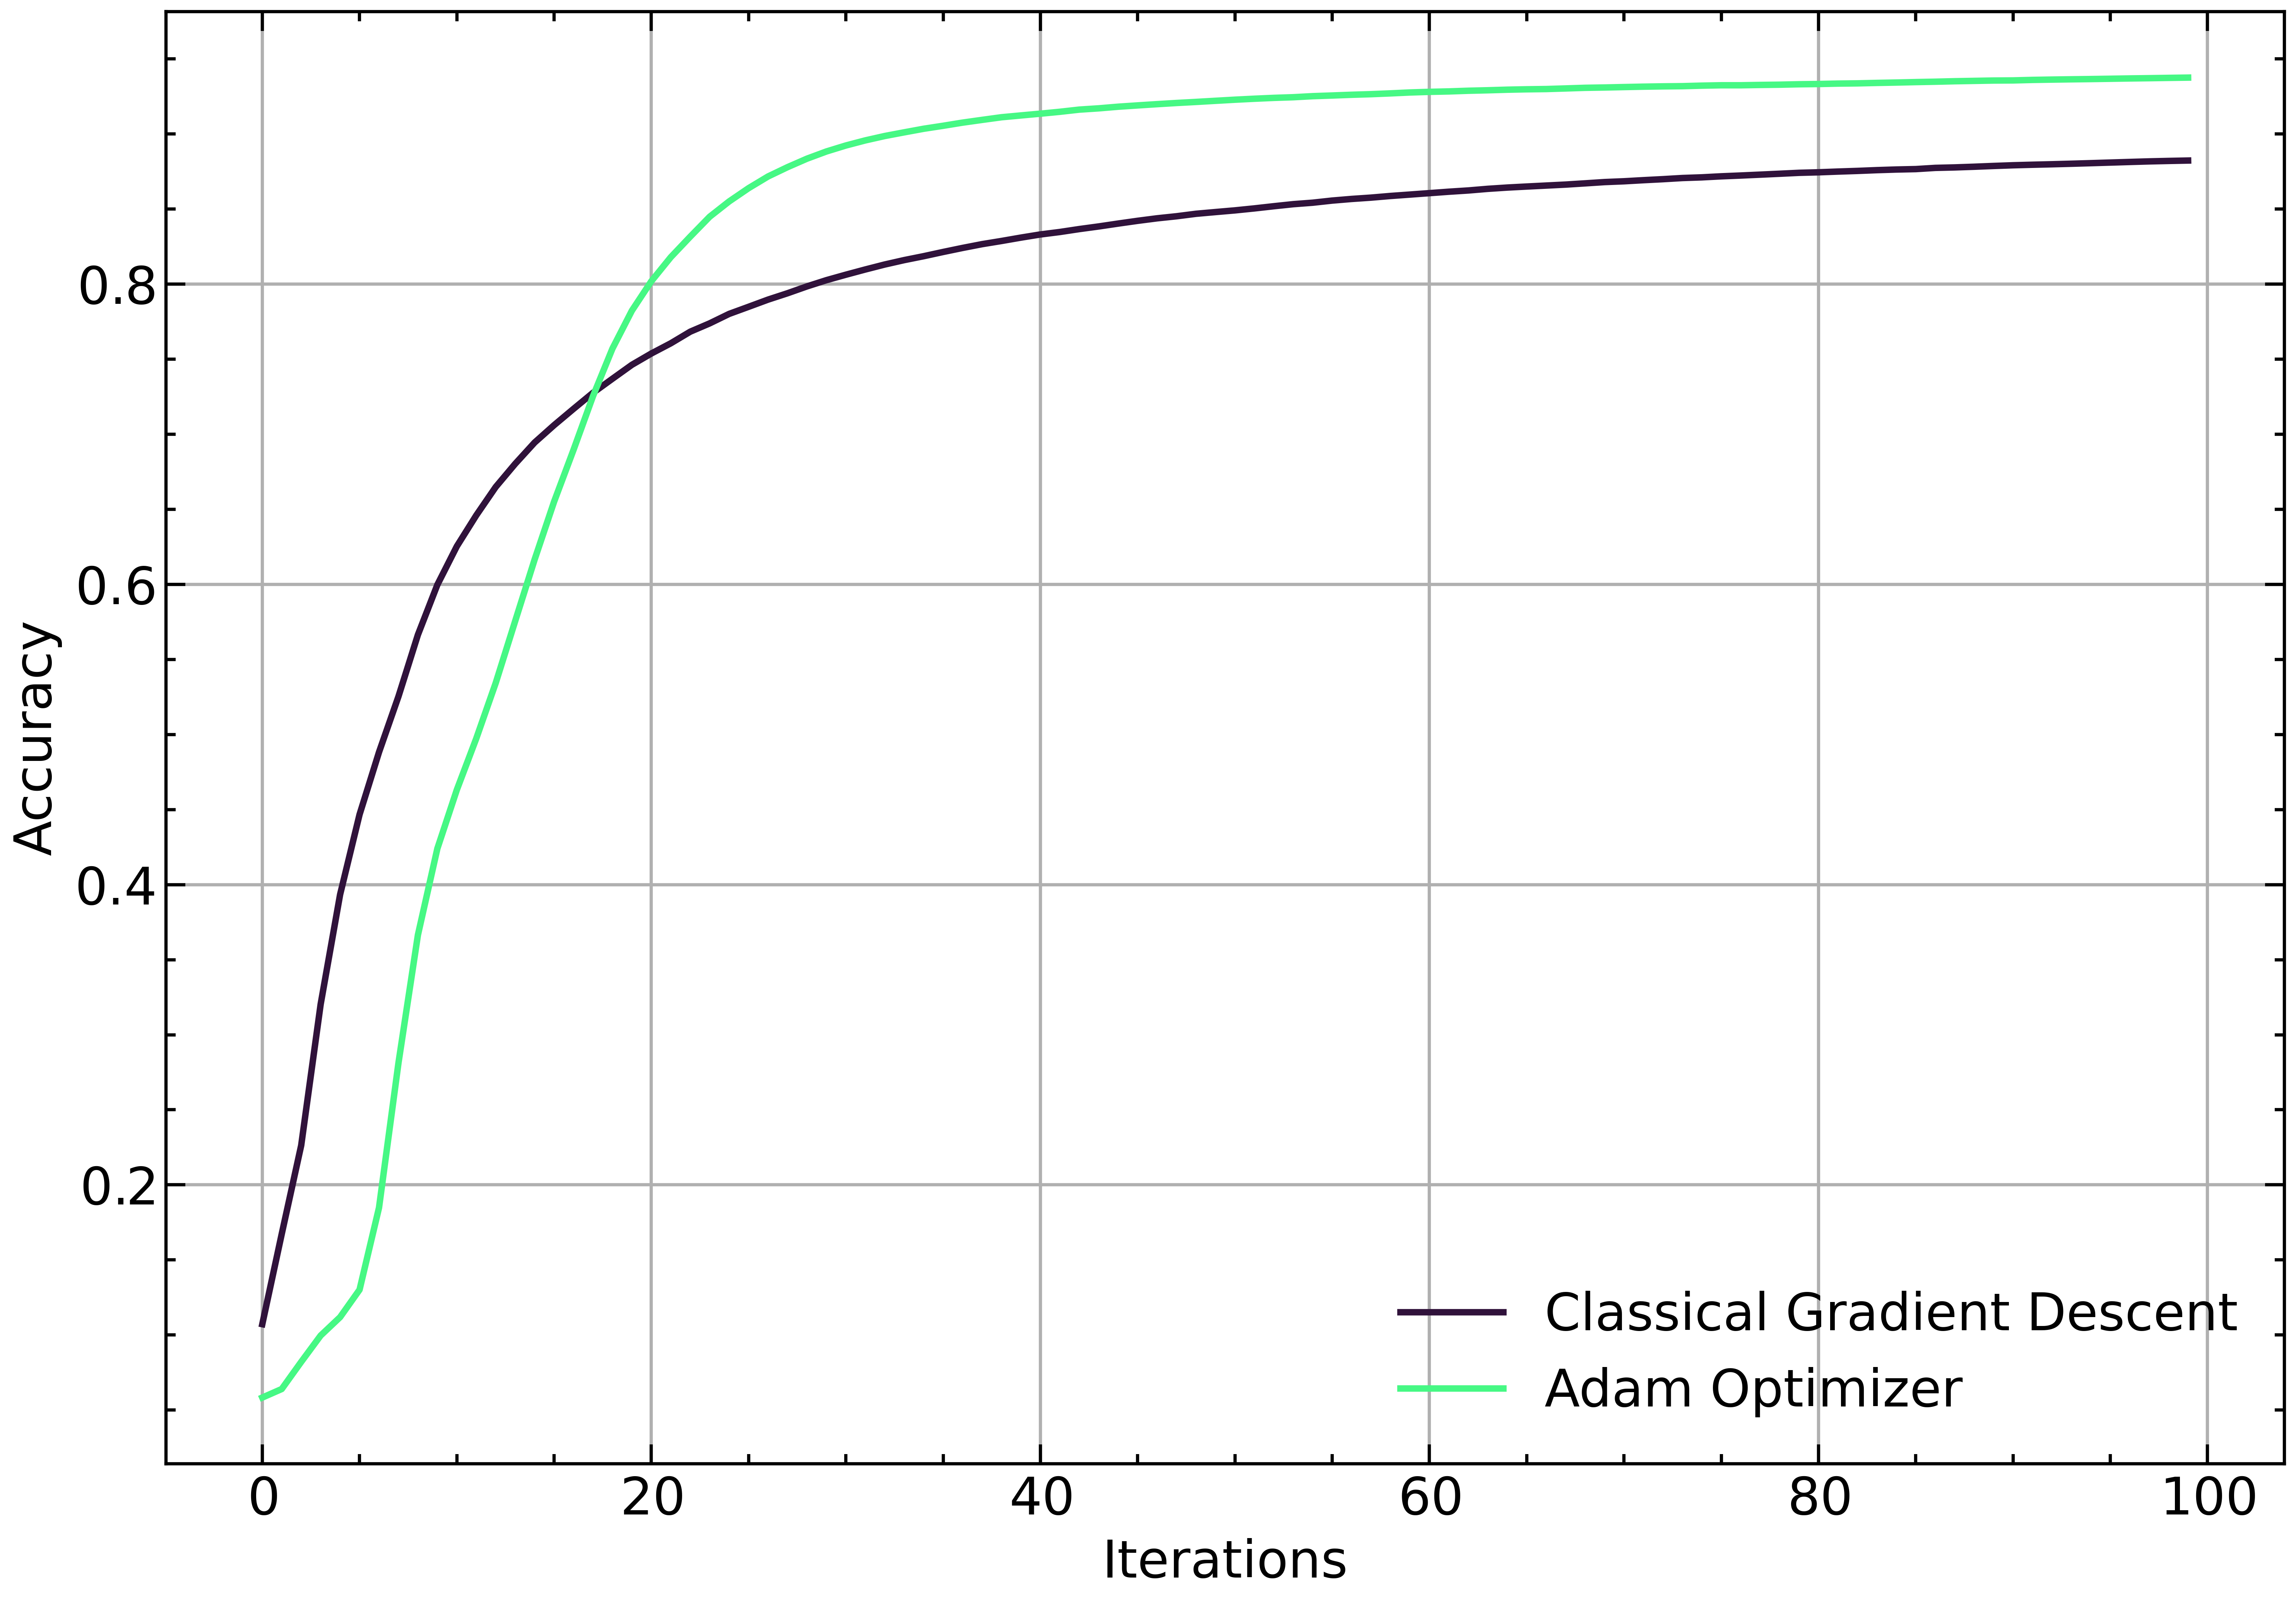

In [55]:
# Graph Accuracy
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

ax.plot(accuracies_classical, label='Classical Gradient Descent', color=colors[0], linestyle='-')
ax.plot(accuracies_adam, label='Adam Optimizer', color=colors[-1], linestyle='-')

plt.grid()

# plt.title('Accuracy Comparison')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Hyperparameter exploration

#### 5-fold Cross-validation

In [9]:
from tqdm.notebook import tqdm

In [10]:
from sklearn.model_selection import KFold
import numpy as np

# beta1 and beta2 values
beta1s = [0.1, 0.9]
beta2s = [0.1, 0.999]

n_folds = 5

# initialize dictionary to store results
results = dict()

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

for beta1 in tqdm(beta1s, leave=True):
    for beta2 in tqdm(beta2s, leave=False):
        fold_accuracies = []
        fold_losses = []

        for train_index, val_index in kf.split(trainX.T):
            # splitting data into training and validation for the current fold
            X_train, X_val = trainX[:, train_index], trainX[:, val_index]
            Y_train, Y_val = trainY[train_index], trainY[val_index]

            # train the model
            W1, b1, W2, b2, losses_adam, accuracies_adam = gradient_descent_with_adam(
                X_train, Y_train, 0.001, 1000, beta1, beta2, 1e-8
            )
            
            fold_accuracies.append(accuracies_adam)

        # for each beta1, beta2 combination
        results[(beta1, beta2)] = {'accuracies': fold_accuracies}


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Iteration:  0
[2 8 5 ... 5 5 5] [5 0 4 ... 3 5 6]
0.0696875
Iteration:  10
[2 8 5 ... 5 5 5] [5 0 4 ... 3 5 6]
0.07610416666666667
Iteration:  20
[2 5 6 ... 5 5 5] [5 0 4 ... 3 5 6]
0.0915625
Iteration:  30
[2 5 6 ... 5 5 6] [5 0 4 ... 3 5 6]
0.1238125
Iteration:  40
[5 8 6 ... 5 6 6] [5 0 4 ... 3 5 6]
0.176375
Iteration:  50
[3 8 6 ... 3 6 6] [5 0 4 ... 3 5 6]
0.23677083333333335
Iteration:  60
[3 3 6 ... 3 6 0] [5 0 4 ... 3 5 6]
0.29475
Iteration:  70
[3 3 7 ... 3 6 0] [5 0 4 ... 3 5 6]
0.355125
Iteration:  80
[3 0 7 ... 3 6 0] [5 0 4 ... 3 5 6]
0.41739583333333335
Iteration:  90
[3 0 7 ... 3 5 0] [5 0 4 ... 3 5 6]
0.48270833333333335
Iteration:  100
[3 0 4 ... 3 5 0] [5 0 4 ... 3 5 6]
0.5285416666666667
Iteration:  110
[3 0 4 ... 3 5 0] [5 0 4 ... 3 5 6]
0.570875
Iteration:  120
[3 0 4 ... 3 5 0] [5 0 4 ... 3 5 6]
0.6115
Iteration:  130
[3 0 4 ... 3 5 0] [5 0 4 ... 3 5 6]
0.6474791666666667
Iteration:  140
[3 0 4 ... 3 5 0] [5 0 4 ... 3 5 6]
0.6800208333333333
Iteration:  150
[3 0 4

Iteration:  220
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.8318541666666667
Iteration:  230
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.8424166666666667
Iteration:  240
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.8520625
Iteration:  250
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.8596041666666666
Iteration:  260
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.8674583333333333
Iteration:  270
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.8741041666666667
Iteration:  280
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.8795833333333334
Iteration:  290
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.8854791666666667
Iteration:  300
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.89
Iteration:  310
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.89425
Iteration:  320
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.89775
Iteration:  330
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.9008958333333333
Iteration:  340
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.9033333333333333
Iteration:  350
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.9055416666666667
Iteration:  360
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]

Iteration:  430
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.912375
Iteration:  440
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9132916666666666
Iteration:  450
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9141875
Iteration:  460
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9153958333333333
Iteration:  470
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9166875
Iteration:  480
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9175416666666667
Iteration:  490
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9185208333333333
Iteration:  500
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9191875
Iteration:  510
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.91975
Iteration:  520
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.92025
Iteration:  530
[5 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9209583333333333
Iteration:  540
[5 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9214791666666666
Iteration:  550
[5 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9219166666666667
Iteration:  560
[5 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.9226666666666666
Iteration:  570
[5 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.92333333333

Iteration:  650
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.932625
Iteration:  660
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9331458333333333
Iteration:  670
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9335833333333333
Iteration:  680
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9341666666666667
Iteration:  690
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9345416666666667
Iteration:  700
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9349375
Iteration:  710
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9354791666666666
Iteration:  720
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9357708333333333
Iteration:  730
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9360625
Iteration:  740
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9364791666666666
Iteration:  750
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9368333333333333
Iteration:  760
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9371666666666667
Iteration:  770
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9373541666666667
Iteration:  780
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9375416666666667
Iteration:  790
[5 0 4 ... 5 6 8] 

Iteration:  860
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9429583333333333
Iteration:  870
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9432291666666667
Iteration:  880
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9436458333333333
Iteration:  890
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9439791666666667
Iteration:  900
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9442916666666666
Iteration:  910
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9445625
Iteration:  920
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9448333333333333
Iteration:  930
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9448958333333334
Iteration:  940
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9451041666666666
Iteration:  950
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9452083333333333
Iteration:  960
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9453958333333333
Iteration:  970
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9455208333333334
Iteration:  980
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9455833333333333
Iteration:  990
[5 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9457083333333334
Iteration:  0
[

Iteration:  70
[4 1 7 ... 0 9 9] [4 1 9 ... 5 6 8]
0.32816666666666666
Iteration:  80
[4 1 7 ... 1 9 9] [4 1 9 ... 5 6 8]
0.36
Iteration:  90
[4 1 0 ... 1 9 9] [4 1 9 ... 5 6 8]
0.39329166666666665
Iteration:  100
[9 1 0 ... 8 9 0] [4 1 9 ... 5 6 8]
0.45335416666666667
Iteration:  110
[9 1 0 ... 8 9 0] [4 1 9 ... 5 6 8]
0.5062916666666667
Iteration:  120
[9 1 9 ... 8 9 0] [4 1 9 ... 5 6 8]
0.55075
Iteration:  130
[9 1 9 ... 8 9 0] [4 1 9 ... 5 6 8]
0.5883958333333333
Iteration:  140
[9 1 9 ... 8 9 0] [4 1 9 ... 5 6 8]
0.6215208333333333
Iteration:  150
[9 1 9 ... 8 9 0] [4 1 9 ... 5 6 8]
0.648
Iteration:  160
[9 1 9 ... 8 6 0] [4 1 9 ... 5 6 8]
0.6700208333333333
Iteration:  170
[9 1 9 ... 8 6 0] [4 1 9 ... 5 6 8]
0.6893541666666667
Iteration:  180
[9 1 9 ... 8 6 0] [4 1 9 ... 5 6 8]
0.7055416666666666
Iteration:  190
[9 1 9 ... 8 6 8] [4 1 9 ... 5 6 8]
0.7194375
Iteration:  200
[9 1 9 ... 8 6 8] [4 1 9 ... 5 6 8]
0.731125
Iteration:  210
[9 1 9 ... 8 6 8] [4 1 9 ... 5 6 8]
0.742958333

Iteration:  290
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8267916666666667
Iteration:  300
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8327916666666667
Iteration:  310
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8375
Iteration:  320
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8418541666666667
Iteration:  330
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8467708333333334
Iteration:  340
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.850125
Iteration:  350
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8535833333333334
Iteration:  360
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8571458333333334
Iteration:  370
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8604375
Iteration:  380
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8630208333333333
Iteration:  390
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8649166666666667
Iteration:  400
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.866625
Iteration:  410
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8690208333333334
Iteration:  420
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8710208333333334
Iteration:  430
[3 0 4 ... 8 3 8] [5 0 4 ... 8 

Iteration:  500
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8868958333333333
Iteration:  510
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.888
Iteration:  520
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.889
Iteration:  530
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8897708333333333
Iteration:  540
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8908333333333334
Iteration:  550
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8915
Iteration:  560
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8922708333333333
Iteration:  570
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8931875
Iteration:  580
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8941041666666667
Iteration:  590
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8946666666666667
Iteration:  600
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.895625
Iteration:  610
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8963958333333333
Iteration:  620
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8971666666666667
Iteration:  630
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8975208333333333
Iteration:  640
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.898104166

Iteration:  730
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8939166666666667
Iteration:  740
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.894375
Iteration:  750
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8950625
Iteration:  760
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8956041666666666
Iteration:  770
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8962708333333333
Iteration:  780
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8969375
Iteration:  790
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8974583333333334
Iteration:  800
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8979791666666667
Iteration:  810
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8983333333333333
Iteration:  820
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8990208333333334
Iteration:  830
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.8996666666666666
Iteration:  840
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9001041666666667
Iteration:  850
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9007083333333333
Iteration:  860
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.901375
Iteration:  870
[3 0 1 ... 5 6 8] [5 0 1 ...

  0%|          | 0/2 [00:00<?, ?it/s]

Iteration:  0
[9 9 9 ... 9 9 9] [5 0 4 ... 3 5 6]
0.10285416666666666
Iteration:  10
[9 8 9 ... 9 9 9] [5 0 4 ... 3 5 6]
0.1315625
Iteration:  20
[8 0 8 ... 8 1 8] [5 0 4 ... 3 5 6]
0.14133333333333334
Iteration:  30
[4 0 1 ... 1 1 1] [5 0 4 ... 3 5 6]
0.1754375


C:\Users\Hermes\AppData\Local\Temp\ipykernel_11244\2082559469.py:13: RuntimeWarning: overflow encountered in exp
  A = np.exp(Z) / sum(np.exp(Z))
C:\Users\Hermes\AppData\Local\Temp\ipykernel_11244\2082559469.py:13: RuntimeWarning: invalid value encountered in divide
  A = np.exp(Z) / sum(np.exp(Z))


Iteration:  40
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  50
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  60
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  70
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  80
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  90
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  100
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  110
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  120
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  130
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  140
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  150
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  160
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.09891666666666667
Iteration:  170
[0 0 0 ... 0 0 0] [5 0 4 ... 3 5 6]
0.0989166666666666

Iteration:  200
[0 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.3195208333333333
Iteration:  210
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.30420833333333336
Iteration:  220
[4 1 4 ... 9 8 9] [4 1 9 ... 5 6 8]
0.2990625
Iteration:  230
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.3290625
Iteration:  240
[0 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.3319166666666667
Iteration:  250
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.3135
Iteration:  260
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.31445833333333334
Iteration:  270
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.34172916666666664
Iteration:  280
[9 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.33545833333333336
Iteration:  290
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.319625
Iteration:  300
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.3367291666666667
Iteration:  310
[9 1 4 ... 8 8 8] [4 1 9 ... 5 6 8]
0.3471458333333333
Iteration:  320
[9 1 4 ... 8 8 8] [4 1 9 ... 5 6 8]
0.3333541666666667
Iteration:  330
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]
0.3384375
Iteration:  340
[4 1 4 ... 9 8 8] [4 1 9 ... 5 6 8]

Iteration:  420
[9 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.37425
Iteration:  430
[9 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3790625
Iteration:  440
[9 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3796041666666667
Iteration:  450
[9 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.378
Iteration:  460
[8 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3823125
Iteration:  470
[9 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3822291666666667
Iteration:  480
[8 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3804375
Iteration:  490
[8 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.38529166666666664
Iteration:  500
[9 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3840625
Iteration:  510
[8 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3827291666666667
Iteration:  520
[8 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.38789583333333333
Iteration:  530
[8 9 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3860625
Iteration:  540
[8 8 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.3863333333333333
Iteration:  550
[8 8 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.38985416666666667
Iteration:  560
[8 8 4 ... 8 9 8] [5 0 4 ... 8 3 8]
0.38810416666666664


Iteration:  630
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.70275
Iteration:  640
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7091458333333334
Iteration:  650
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7049375
Iteration:  660
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7134791666666667
Iteration:  670
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7101458333333334
Iteration:  680
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7203541666666666
Iteration:  690
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7206875
Iteration:  700
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7206875
Iteration:  710
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7342708333333333
Iteration:  720
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7274166666666667
Iteration:  730
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.742125
Iteration:  740
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7355833333333334
Iteration:  750
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7458541666666667
Iteration:  760
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.7468541666666667
Iteration:  770
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.

Iteration:  850
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.48233333333333334
Iteration:  860
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.4852708333333333
Iteration:  870
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.4824583333333333
Iteration:  880
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.48533333333333334
Iteration:  890
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.48391666666666666
Iteration:  900
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.4866666666666667
Iteration:  910
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.484
Iteration:  920
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.48691666666666666
Iteration:  930
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.486625
Iteration:  940
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.48754166666666665
Iteration:  950
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.4874791666666667
Iteration:  960
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.48833333333333334
Iteration:  970
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.4897916666666667
Iteration:  980
[1 6 1 ... 7 6 7] [5 0 1 ... 5 6 8]
0.48891666666666667
Iteration:  990
[1 6 1

Iteration:  60
[6 0 8 ... 8 9 6] [4 1 9 ... 5 6 8]
0.31125
Iteration:  70
[4 0 8 ... 8 6 8] [4 1 9 ... 5 6 8]
0.3682916666666667
Iteration:  80
[4 1 8 ... 8 6 8] [4 1 9 ... 5 6 8]
0.4310625
Iteration:  90
[4 1 8 ... 3 6 8] [4 1 9 ... 5 6 8]
0.5005833333333334
Iteration:  100
[4 1 9 ... 3 6 8] [4 1 9 ... 5 6 8]
0.5609583333333333
Iteration:  110
[4 1 9 ... 8 6 8] [4 1 9 ... 5 6 8]
0.6077708333333334
Iteration:  120
[4 1 9 ... 8 6 8] [4 1 9 ... 5 6 8]
0.6453125
Iteration:  130
[4 1 9 ... 8 6 8] [4 1 9 ... 5 6 8]
0.6756666666666666
Iteration:  140
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.7013125
Iteration:  150
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.7235208333333333
Iteration:  160
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.7430208333333334
Iteration:  170
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.7584791666666667
Iteration:  180
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.7720833333333333
Iteration:  190
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6 8]
0.7840833333333334
Iteration:  200
[4 1 9 ... 5 6 8] [4 1 9 ... 5 6

Iteration:  280
[3 0 4 ... 8 3 9] [5 0 4 ... 8 3 8]
0.7708125
Iteration:  290
[3 0 4 ... 8 3 9] [5 0 4 ... 8 3 8]
0.7785833333333333
Iteration:  300
[3 0 4 ... 8 3 9] [5 0 4 ... 8 3 8]
0.7855208333333333
Iteration:  310
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.7913958333333333
Iteration:  320
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.7960625
Iteration:  330
[5 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8014166666666667
Iteration:  340
[5 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8064583333333334
Iteration:  350
[5 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.810625
Iteration:  360
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8153125
Iteration:  370
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8194375
Iteration:  380
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8233333333333334
Iteration:  390
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8267291666666666
Iteration:  400
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8302916666666667
Iteration:  410
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]
0.8335416666666666
Iteration:  420
[3 0 4 ... 8 3 8] [5 0 4 ... 8 3 8]


Iteration:  500
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8904583333333334
Iteration:  510
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8913333333333333
Iteration:  520
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8921875
Iteration:  530
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8931666666666667
Iteration:  540
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8935833333333333
Iteration:  550
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8946666666666667
Iteration:  560
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8955208333333333
Iteration:  570
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8964166666666666
Iteration:  580
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.896875
Iteration:  590
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8975208333333333
Iteration:  600
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8982083333333334
Iteration:  610
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8991458333333333
Iteration:  620
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8996666666666666
Iteration:  630
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9004375
Iteration:  640
[5 0 4 ... 5 6 8] 

Iteration:  710
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.91075
Iteration:  720
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.91125
Iteration:  730
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9118958333333333
Iteration:  740
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.91225
Iteration:  750
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9129166666666667
Iteration:  760
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9134375
Iteration:  770
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9138541666666666
Iteration:  780
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.91425
Iteration:  790
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9145625
Iteration:  800
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9150416666666666
Iteration:  810
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9153958333333333
Iteration:  820
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9155625
Iteration:  830
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9159166666666667
Iteration:  840
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9163958333333333
Iteration:  850
[3 0 1 ... 5 6 8] [5 0 1 ... 5 6 8]
0.9171041666666667
Iterat

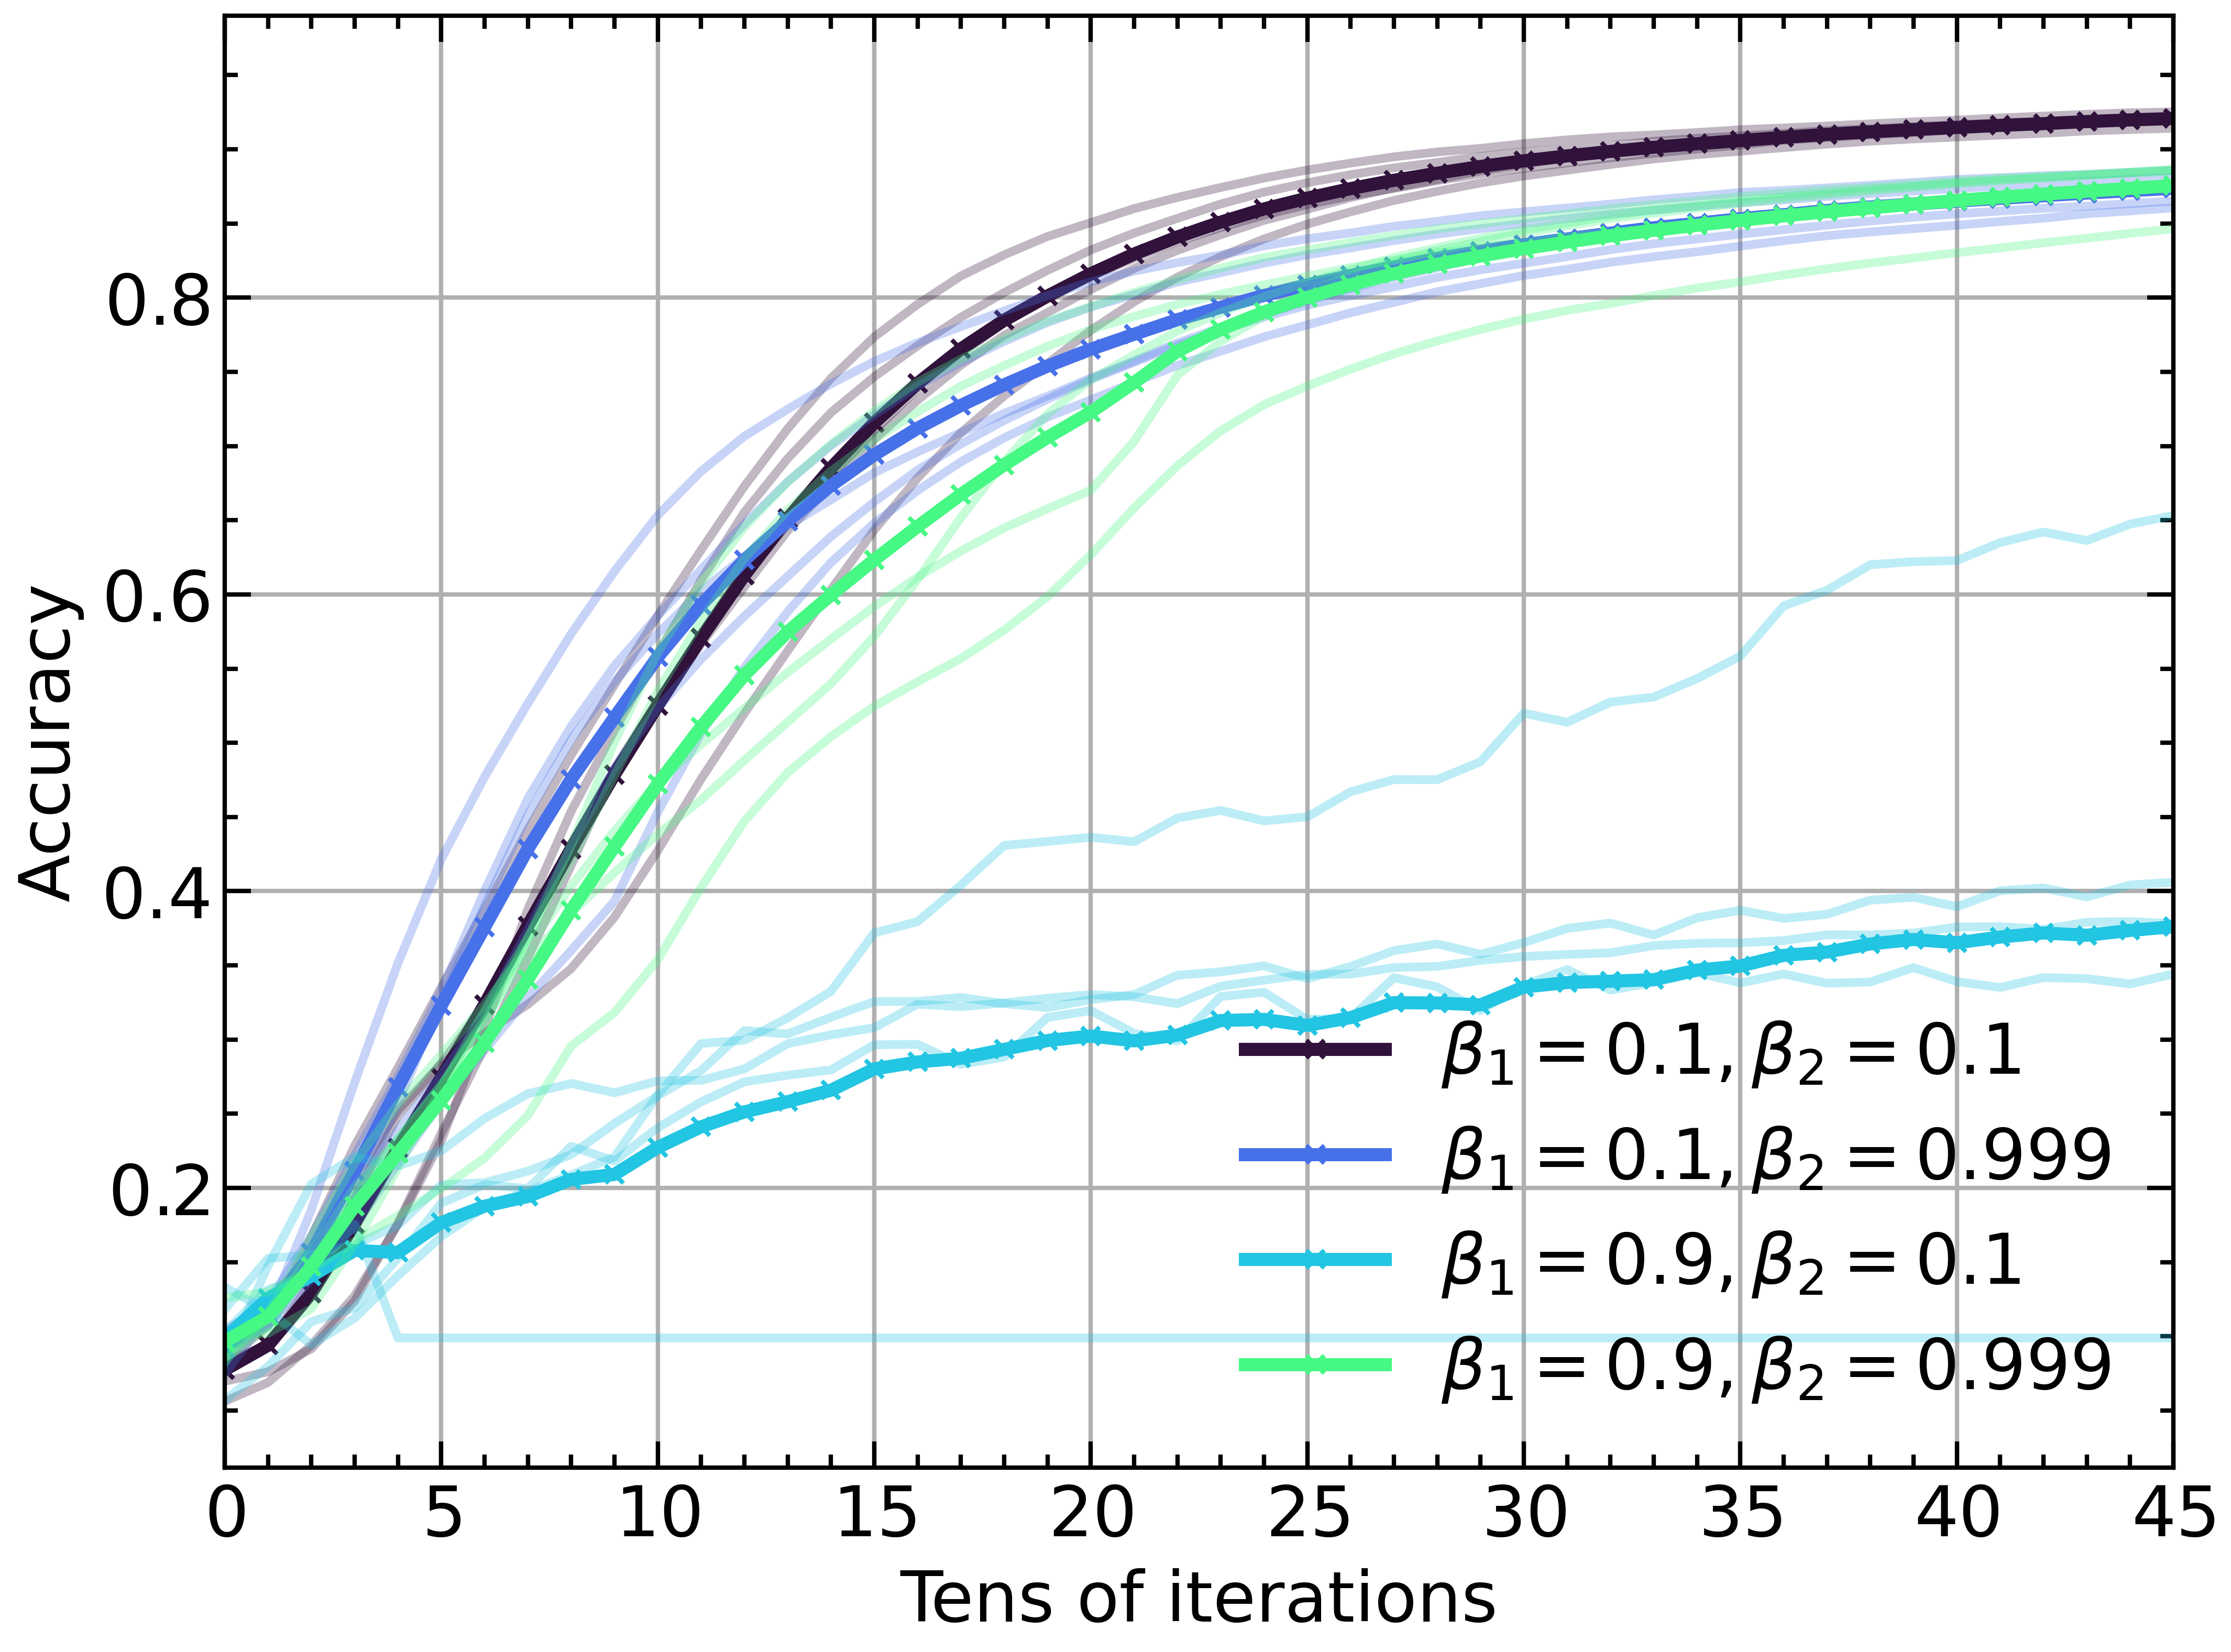

<Figure size 9000x4800 with 0 Axes>

In [17]:
# define the beta1s and beta2s
beta1s = [0.1, 0.9]
beta2s = [0.1, 0.999]

# generating our color gradient
colors = plt.cm.turbo(np.linspace(0, 0.4, len(beta1s) * len(beta2s)))

# plot
color_index = 0

for (beta1, beta2), data in results.items():
    accuracies = data['accuracies']
    num_iterations = len(accuracies[0])
    
    # Calculate average accuracies across folds for each iteration
    avg_accuracies = [np.mean([fold_acc[i] for fold_acc in accuracies]) for i in range(num_iterations)]

    # Plot each fold's accuracies (transparent lines)
    for fold_acc in accuracies:
        plt.plot(fold_acc, alpha=0.3, linestyle="-", color=colors[color_index])

    # Plot average accuracy (opaque line with thicker width)
    plt.plot(avg_accuracies, linewidth=3, linestyle="-", color=colors[color_index], label=fr'$\beta_1={beta1}, \beta_2={beta2}$', marker="x", markersize=4)

    color_index += 1
    
plt.xlim(0, 45)
plt.xlabel('Tens of iterations')
plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Iterations for Different Beta Values (5-Fold CV)')
plt.legend()
plt.grid(True)
plt.figure(figsize=(15,8))
plt.show()
